In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [15]:
import os
os.listdir()

['datalab',
 '.config',
 '.ipython',
 '.cache',
 '.keras',
 '.local',
 'drive',
 '.forever',
 '.gdfuse']

In [0]:
import numpy as np
import os 
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import pickle
import gzip
from time import time
import time

In [0]:
def load_data():
    with gzip.open('drive/colab/bhand/bhand.pkl.gz', 'rb') as f:
        if sys.version_info.major > 2:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        else:
            train_set, valid_set, test_set = pickle.load(f)

    train_x, train_y = train_set
    
    #train_x = np.reshape(train_x, [-1, 32, 32, 1])
    

    #train_x = (train_x.astype(np.float32) - 127.5) / 127.5
    #train_x = np.expand_dims(train_x, axis=3)
    

    return train_x

In [0]:
train_x =load_data()

In [18]:
train_x.shape

(50000, 1024)

In [19]:
type(train_x)

numpy.ndarray

In [0]:
train_x = np.reshape(train_x,(train_x.shape[0],32,32,1)) 

In [23]:
img_w,img_h = train_x.shape[1:3]
train_x.shape

(50000, 32, 32, 1)

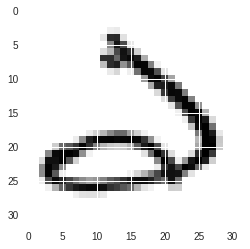

In [24]:
plt.imshow(train_x[4242,:,:,0], cmap='Greys')

In [0]:
def discriminator_builder(depth=64,p=0.4):
    
    inputs = Input((img_w,img_h,1))
    
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [26]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [0]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])

In [0]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
    inputs = Input((z_dim,))
    
    dense1 = Dense(8*8*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1) 
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((8,8,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [31]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_5 (Activation)    (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 64)        0         
__________

In [0]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

In [33]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 32, 32, 1)         497761    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4311553   
Total params: 4,809,314
Trainable params: 4,801,010
Non-trainable params: 8,304
_________________________________________________________________


In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [0]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    start_time = time.time()
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(train_x[np.random.choice(train_x.shape[0],batch,replace=False)],(batch,32,32,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)
            gen_imgs = gen_imgs.reshape(16,32,32)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k], interpolation='nearest', cmap = 'gray_r')
                plt.axis('off')
                
            plt.tight_layout()
            plt.savefig('drive/colab/bhand/gan/img/generated_%d.png' % (i+1))
            plt.show()
            
            
        end_time = (time.time()-start_time)
    
    return a_metrics, d_metrics, end_time

0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100
200
300
400
Epoch #500
499: [D loss: 0.600810, acc: 0.737146]  [A loss: 1.257019, acc: 0.145666]


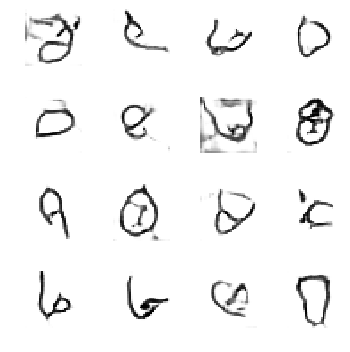

500
600
700
800
900
Epoch #1000
999: [D loss: 0.590381, acc: 0.737886]  [A loss: 1.246732, acc: 0.133986]


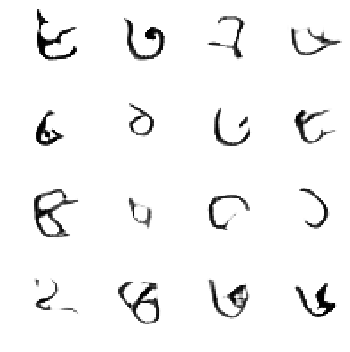

250.58062744140625

In [54]:
a_metrics_complete, d_metrics_complete, end_time = train(epochs=1000)
with open('drive/colab/bhand/gan/img/res.pkl','wb')as outpt:
  pickle.dump((a_metrics_complete, d_metrics_complete), outpt)

end_time

In [0]:
with open('drive/colab/bhand/gan/img/res.pkl', 'rb')as rbb:
    a,b = pickle.load(rbb)

Text(0,0.5,'Loss')

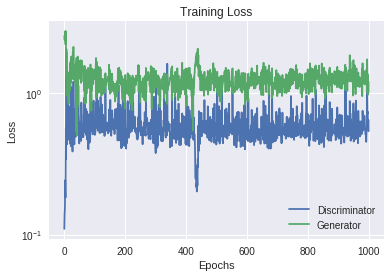

In [56]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a],
        'Discriminator': [metric[0] for metric in b],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0,0.5,'Accuracy')

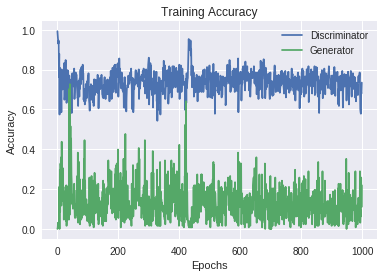

In [57]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a],
        'Discriminator': [metric[1] for metric in b],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")